# PCA Jaccart 

workflow:

1. Obtain reactions and metabolites for Human1 and Mitocore
Reaction origin need to be identified 
Metabolites do not need identification

2. Standarize metabolites ploted (ignore compartment: e.g. MAM01371c, MAM01334c) to fill binary matrix

3. Set the binary matrix and fill up
    reactions --> columns
    metabolites --> rows

4. Check repeated

4. Apply PCoA using Jaccart index  (represents similarity and diversity of samples)
5. Display and format PCA


In [3]:
import cobra
import re
from urllib import request 
from pprint import pprint
import pandas as pd
import cobra.flux_analysis
import numpy as np
import copy
import os 
import sklearn 

In [4]:
# read models
Human1 = cobra.io.read_sbml_model("Human-GEM.xml")
mitocore= cobra.io.read_sbml_model("Cleaned_Mitocore_changed_metabolites_metanetx.chemical.xml")

# 1. Obtain reactions and metabolites for Human1 and Mitocore

In [ ]:
# extract reactions and metabolites from models
def extract_human1_in_mito(model, component):

    Hum1_in_Mitocore = []
    Hum1=[]

    # Iterate over the specified component (e.g., reactions or metabolites)
    for comp in getattr(model, component):

        #extract human1 ids from mitocore (from annotations)
        if model == mitocore:
            Human1_id = comp.annotation.get('Human1', None)
            if Human1_id is not None and component == 'reactions':
                #mark reactions with human1 ids comming from Mitocore model
                Hum1_in_Mitocore.append(Human1_id + '_mito')
            #do not mark metabolites with human1 ids comming from Mitocore model
            elif Human1_id is not None and component != 'reactions':
                Hum1_in_Mitocore.append(Human1_id) 

        #extract human1 ids from human1 model (model id)
        elif model == Human1:
            Human1_id = comp.id
            if Human1_id is not None:
                Hum1.append(Human1_id)

    return Hum1_in_Mitocore if model == mitocore else Hum1

Extract metabolites and reactions of Mitocore

In [ ]:
mito_reactions_in_human1= extract_human1_in_mito(mitocore,'reactions')
print(len(mito_reactions_in_human1))
#proof if there are duplicates
mito_1=set(mito_reactions_in_human1)
print(len(mito_1))

mito_mets_in_human1= extract_human1_in_mito(mitocore,'metabolites')
print(len(mito_mets_in_human1))
#proof if there are duplicates
mito_1=set(mito_mets_in_human1)
print(len(mito_1))

395
346
421
261


Extract metabolites and reactions of Human1

In [7]:
reactions_in_human1= extract_human1_in_mito(Human1,'reactions')
print(len(reactions_in_human1))
#proof if there are duplicates
mito_1=set(reactions_in_human1)
print(mito_1)

mets_in_human1= extract_human1_in_mito(Human1,'metabolites')
print(len(mets_in_human1))
#proof if there are duplicates
mito_1=set(mets_in_human1)
print(len(mito_1))

12971
{'MAR09261', 'MAR08869', 'MAR01267', 'MAR04821', 'MAR06802', 'MAR10640', 'MAR05830', 'MAR09183', 'MAR08152', 'MAR01796', 'MAR10981', 'MAR03640', 'MAR05557', 'MAR04657', 'MAR03735', 'MAR09396', 'MAR08552', 'MAR11552', 'MAR07044', 'MAR08145', 'MAR11917', 'MAR06678', 'MAR06756', 'MAR01560', 'MAR04087', 'MAR03477', 'MAR02885', 'MAR09742', 'MAR11555', 'MAR00686', 'MAR03462', 'MAR07189', 'MAR10536', 'MAR12909', 'MAR02598', 'MAR10354', 'MAR04932', 'MAR11553', 'MAR04310', 'MAR03304', 'MAR08486', 'MAR10200', 'MAR01593', 'MAR06618', 'MAR11240', 'MAR01941', 'MAR06372', 'MAR12486', 'MAR01283', 'MAR10942', 'MAR11406', 'MAR04666', 'MAR01147', 'MAR13085', 'MAR11213', 'MAR04319', 'MAR05279', 'MAR03951', 'MAR10711', 'MAR01135', 'MAR07292', 'MAR09662', 'MAR12853', 'MAR11825', 'MAR10157', 'MAR12377', 'MAR09860', 'MAR12141', 'MAR11396', 'MAR12908', 'MAR20100', 'MAR08423', 'MAR01078', 'MAR04741', 'MAR12541', 'MAR11647', 'MAR20016', 'MAR00698', 'MAR02719', 'MAR06426', 'MAR12035', 'MAR12170', 'MAR08757

# 2. Standarize metabolites plotted to fill binary matrix
(ignore compartment: e.g. MAM01371c, MAM01334c)

1. Open organizers to collect reactions, metabolites and a tuple that contains both to fill up binary matrix
2. Extract reactions and metabolites from Mitocore (if Human1 id available), randomize metabolites and reactions with same Human1 identifier.
3. Extract reactions and metabolites ids from Human1 
4. Build binary matrix and fill it
6. Save binary matrix into csv


In [ ]:
import pandas as pd
from sklearn.metrics import pairwise_distances
from skbio import DistanceMatrix
from skbio.stats.ordination import pcoa

# Pattern to match Human1 metabolite ids with compartment assignment (e.g., MAM01234, MAM01234c, MAM01234m)
pattern_met_human1 = re.compile(r'^(MAM0\d{4})[a-zA-Z]?$')


# 1. Collect all reactions (mapped to Human1 ids)
all_reactions = []
#collect all metabolites (normalized to base id without compartment) and remove duplicates
all_metabolites = set()
# metabolites which are in each reaction
reaction_metabolite_map = {}

# 2. From Mitocore (mapped to Human1 ids if available)
for react in mitocore.reactions:
    human1_id = react.annotation.get('Human1', None)
    # if reaction in mitocore has Human1 id, otherwise skip
    if human1_id is not None:  # only take mapped reactions
        base_react= human1_id
        classif_id=base_react + '_mit'
        all_reactions.append(classif_id)
        #store the reaction with human1 id into a mapping dictionary
        reaction_metabolite_map[classif_id] = []
        
        for met in react.metabolites:
            met_human1_id = met.annotation.get('Human1', None)
            # if  metabolite in mitocore has Human1 id, otherwise skip
            if met_human1_id is not None:
                match = pattern_met_human1.match(met_human1_id)
                # Check if the pattern matched
                if match: 
                    base_met = match.group(1)
                    all_metabolites.add(base_met)
                    #store the metabolites in the reaction into the mapping dictionary
                    reaction_metabolite_map[classif_id].append(base_met)

# 3. From Human1 (direct ids)
for react in Human1.reactions:
    human1_id = react.id
    base_react= human1_id
    classif_id= base_react + '_hum'
    all_reactions.append(classif_id)
    reaction_metabolite_map[classif_id] = []

    for met in react.metabolites:
        met_human1_id = met.id
        match = pattern_met_human1.match(met_human1_id)
        if match:  # Ensure match is not None
            base_met = match.group(1)
            all_metabolites.add(base_met)
            reaction_metabolite_map[classif_id].append(base_met)


print (len(all_reactions))
# there are duplicates in Human1 ids for the mitocore reactions because mitocore has the same reaction specified in different compartments with different reaction.id
all_reactions= set(all_reactions)
print(len(all_reactions))

# 4. Build binary matrix and fill it up
binary_matrix = pd.DataFrame(0, index=sorted(all_metabolites), columns=sorted(all_reactions))

# Fill the binary matrix based on finding normalized metabolite ids in reactions in the binary matrix
for rxn, mets in reaction_metabolite_map.items():
    for base_met in mets:  # already normalized metabolite 
        if base_met in binary_matrix.index:
            binary_matrix.loc[base_met, rxn] = 1

# 6. Save for checking
binary_matrix.to_csv('binary_matrix.csv')

print("Binary matrix shape:", binary_matrix.shape)
print(binary_matrix.head())



13366
13317
Binary matrix shape: (4040, 13317)
          MAR00001_hum  MAR00002_hum  MAR00003_hum  MAR00004_hum  \
MAM00001             0             0             0             0   
MAM00002             0             0             0             0   
MAM00003             0             0             0             0   
MAM00004             0             0             0             0   
MAM00005             0             0             0             0   

          MAR00005_hum  MAR00006_hum  MAR00007_hum  MAR00008_hum  \
MAM00001             0             0             0             0   
MAM00002             0             0             0             0   
MAM00003             0             0             0             0   
MAM00004             0             0             0             0   
MAM00005             0             0             0             0   

          MAR00009_hum  MAR00010_hum  ...  MAR20174_hum  MAR20175_hum  \
MAM00001             0             0  ...             0       

# 3. Check if duplicates in Mitocore (same Human1 id) are errors 
There are reactions in mitocore with the same Human1 id, it had to be checked if the same identifier is caused by unespecificity of the Human1 reactions or by errors during curation


1. Extract duplicates in mitocore with same Human1 id to check if they can be removed or error when adding Human1 ids   
2. Test manually if these duplicates plot the same reaction but with small difference (e.g. compartment specific reactions) or indeed are errors during curation

Note: as exprected duplicates represent just higher specificity of certain reactions in Mitocore compared to Human1 (e.g. transport reactions, ocurring in differet comparments have the same Human1 identifier but different id in Mitocore) so the reactions can be just assumed as one for comparisson.

In [ ]:

# 1. Extract duplicates in mitocore with same Human1 id
# Collect all reactions (mapped to Human1 ids)
all_reactions = {}


for react in mitocore.reactions:
    human1_id = react.annotation.get('Human1', None)
    mito_id= react.id
    # if reaction in mitocore has Human1 id, otherwise skip
    if human1_id is not None:  # only take mapped reactions
        if human1_id not in all_reactions:
            all_reactions[human1_id] = []
        all_reactions[human1_id].append(mito_id)

# extract duplicates in mitocore with same Human1 id to check if they can be removed or error when adding Human1 ids        
duplicates = {hum: mit for hum, mit in all_reactions.items() if len(mit) > 1}

print(f"Found {len(duplicates)} duplicate Human1 mappings")
for hum, mit in duplicates.items():
    print(f"Human1 reaction {hum} maps to Mitocore reactions: {mit}")

Found 49 duplicate Human1 mappings
Human1 reaction MAR04101 maps to Mitocore reactions: ['PEPCK', 'PEPCKm']
Human1 reaction MAR04408 maps to Mitocore reactions: ['FUMm', 'FUM']
Human1 reaction MAR04139 maps to Mitocore reactions: ['MDHm', 'MDH']
Human1 reaction MAR04089 maps to Mitocore reactions: ['ME2m', 'ME2']
Human1 reaction MAR03899 maps to Mitocore reactions: ['r0081', 'ALATA_L']
Human1 reaction MAR04149 maps to Mitocore reactions: ['ACITLm_MitoCore', 'ACITL']
Human1 reaction MAR04016 maps to Mitocore reactions: ['NDPK1m', 'NDPK1']
Human1 reaction MAR04002 maps to Mitocore reactions: ['ADK1m', 'ADK1']
Human1 reaction MAR03827 maps to Mitocore reactions: ['ASPTA', 'ASPTAm']
Human1 reaction MAR02599 maps to Mitocore reactions: ['C160CPT1', 'C160CPT2']
Human1 reaction MAR03975 maps to Mitocore reactions: ['PPA', 'PPAm']
Human1 reaction MAR03912 maps to Mitocore reactions: ['CYSTA', 'CYSTAm']
Human1 reaction MAR06518 maps to Mitocore reactions: ['MCPST', 'MCPSTm_MitoCore']
Human1 rea

In [ ]:
# 2. Test manually if these duplicates plot the same reaction
react= mitocore.reactions.get_by_id('r0514')

print(react.metabolites)
react_human1= react.annotation.get('Human1', None)
print(react)
print('react Human1:',react_human1)

mets= react.metabolites
for met in mets:
    met_id= met.id
    print('met mito:', met_id)
    met_Human1= met.annotation.get('Human1', None)
    print('met hum in mito:', met_Human1)

react_h= Human1.reactions.get_by_id('MAR04655')
print('human1:', react_h)


{<Metabolite nadph_m at 0x2a5a865d0>: -1.0, <Metabolite fol_m at 0x2a5b55490>: -1.0, <Metabolite nadp_m at 0x2a5a86a10>: 1.0, <Metabolite dhf_m at 0x2a5b57650>: 1.0}
r0514: fol_m + nadph_m <=> dhf_m + nadp_m
react Human1: MAR04655
met mito: nadph_m
met hum in mito: MAM02555c
met mito: fol_m
met hum in mito: MAM01830c
met mito: nadp_m
met hum in mito: MAM02554c
met mito: dhf_m
met hum in mito: MAM01700c
human1: MAR04655: MAM01830c + MAM02555c <=> MAM01700c + MAM02554c


# 4. Run PCoA based on distance-matrix calculated with Jaccard distance

In [52]:
# Load binary matrix
binary_matrix = pd.read_csv('binary_matrix.csv', index_col=0)
# Compute Jaccard distance between reactions (transpose so models/reactions are rows)
dist_array = pairwise_distances(binary_matrix.T.values, metric="jaccard")
# DistanceMatrix
dist_matrix = DistanceMatrix(dist_array, ids=binary_matrix.columns.tolist())
# Run PCoA 

pcoa_results = pcoa(dist_matrix)

print(pcoa_results.samples.head())

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2463: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


                   PC1       PC2       PC3       PC4       PC5       PC6  \
MAR00001_hum -0.145656  0.008610 -0.007221 -0.021969 -0.014009 -0.050870   
MAR00002_hum  0.028340 -0.261160 -0.115779  0.051471 -0.047166 -0.027353   
MAR00003_hum  0.028522 -0.261341 -0.115843  0.051588 -0.047149 -0.027139   
MAR00004_hum -0.145193  0.008233 -0.007342 -0.021696 -0.013946 -0.050313   
MAR00005_hum  0.029787 -0.261955 -0.116141  0.051927 -0.048107 -0.027577   

                   PC7       PC8       PC9      PC10  ...  PC13308  PC13309  \
MAR00001_hum -0.009850 -0.001049 -0.022571 -0.010969  ...      0.0      0.0   
MAR00002_hum  0.032779 -0.022708 -0.009419 -0.012135  ...      0.0      0.0   
MAR00003_hum  0.032859 -0.022740 -0.009248 -0.012052  ...      0.0      0.0   
MAR00004_hum -0.009664 -0.001109 -0.022130 -0.010748  ...      0.0      0.0   
MAR00005_hum  0.034778 -0.023574 -0.009237 -0.012312  ...      0.0      0.0   

              PC13310  PC13311  PC13312  PC13313  PC13314  PC13315  

# 5. Vizualization of the PCoA

1. PCoA without classifiers (Mito, Human1)
2. PCoA with classifiers (Mito, Human1)

/var/folders/9p/_1828r2n5gb11k82139j3hz00000gn/T/ipykernel_24867/3066553984.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlabel(f'PCoA1 ({pcoa_results.proportion_explained[0]*100:.2f}%)')
/var/folders/9p/_1828r2n5gb11k82139j3hz00000gn/T/ipykernel_24867/3066553984.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.ylabel(f'PCoA2 ({pcoa_results.proportion_explained[1]*100:.2f}%)')


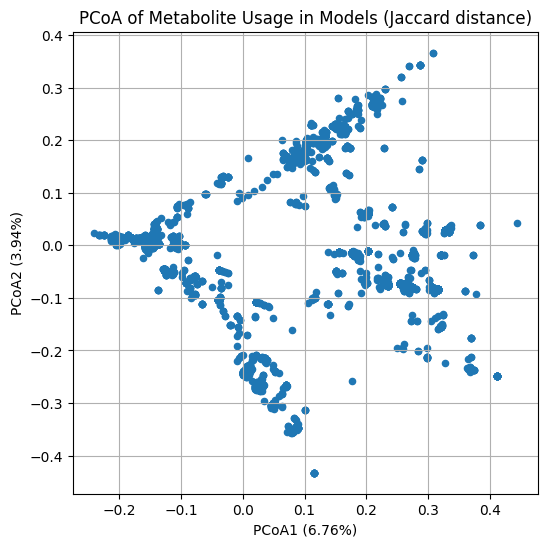

In [ ]:
# 1. PCA plot  option 1 (no classifier)

import matplotlib.pyplot as plt  

coords = pcoa_results.samples

plt.figure(figsize=(6,6))
plt.scatter(coords.iloc[:,0], coords.iloc[:,1], s=20)

plt.xlabel(f'PCoA1 ({pcoa_results.proportion_explained[0]*100:.2f}%)')
plt.ylabel(f'PCoA2 ({pcoa_results.proportion_explained[1]*100:.2f}%)')
plt.title('PCoA of Metabolite Usage in Models (Jaccard distance)')
plt.grid(True)
plt.show()

/var/folders/9p/_1828r2n5gb11k82139j3hz00000gn/T/ipykernel_24867/3994235151.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlabel(f'PCoA1 ({pcoa_results.proportion_explained[0]*100:.2f}%)')
/var/folders/9p/_1828r2n5gb11k82139j3hz00000gn/T/ipykernel_24867/3994235151.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.ylabel(f'PCoA2 ({pcoa_results.proportion_explained[1]*100:.2f}%)')


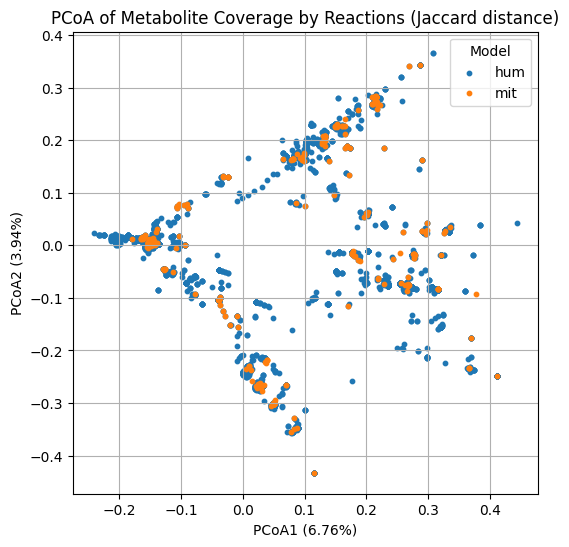

In [ ]:
# 2. PCA cluster option 2 (classifier)

# to keep original PCoA results intact as an object
coords = pcoa_results.samples.copy()

# Extract classifier labels from reaction IDs (suffix "_mit" or "_hum")
coords["label"] = coords.index.str.split("_").str[-1]  

# Plot
plt.figure(figsize=(6,6))
for label, subset in coords.groupby("label"):
    plt.scatter(
        subset.iloc[:, 0], 
        subset.iloc[:, 1], 
        s=10, 
        label=label,
        alpha= 0.5
    )

plt.xlabel(f'PCoA1 ({pcoa_results.proportion_explained[0]*100:.2f}%)')
plt.ylabel(f'PCoA2 ({pcoa_results.proportion_explained[1]*100:.2f}%)')
plt.title('PCoA of Metabolite Coverage by Reactions (Jaccard distance)')
plt.legend(title="Model")
plt.grid(True)
plt.show()

https://rest.kegg.jp/get/M00549